# Rainfall Prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#installing necessary packages 
! pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 9.8 MB 18.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#librairies
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from numpy import log
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pmdarima
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error
import seaborn as sns 
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

Import data and some EDA

In [ ]:
import datetime

In [ ]:
rainfall_dataframe = read_csv('/content/drive/MyDrive/Rainfallprediction/2013/Percip2013UHL.csv', parse_dates=['Time_Tag'],  header=0)

In [ ]:
rainfall_dataframe['Time_Tag'].apply(lambda x : x.month)

0         4
1         4
2         4
3         4
4         4
         ..
22843    12
22844    12
22845    12
22846    12
22847    12
Name: Time_Tag, Length: 22848, dtype: int64

In [ ]:
rainfall_df = read_csv('/content/drive/MyDrive/Rainfallprediction/2013/Percip2013UHL.csv', parse_dates=['Time_Tag'],  header=0,  index_col='Time_Tag')

In [ ]:
rainfall_df.head()
rain_values = rainfall_df[[ 'MeasuredValue']]

In [ ]:
rain_values.head()

,MeasuredValue
Time_Tag,
2013-04-09 12:10:00,0.0
2013-04-09 12:25:00,0.0
2013-04-09 12:40:00,0.0
2013-04-09 12:55:00,0.0
2013-04-09 13:10:00,0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efc5cf49390>],
      dtype=object)

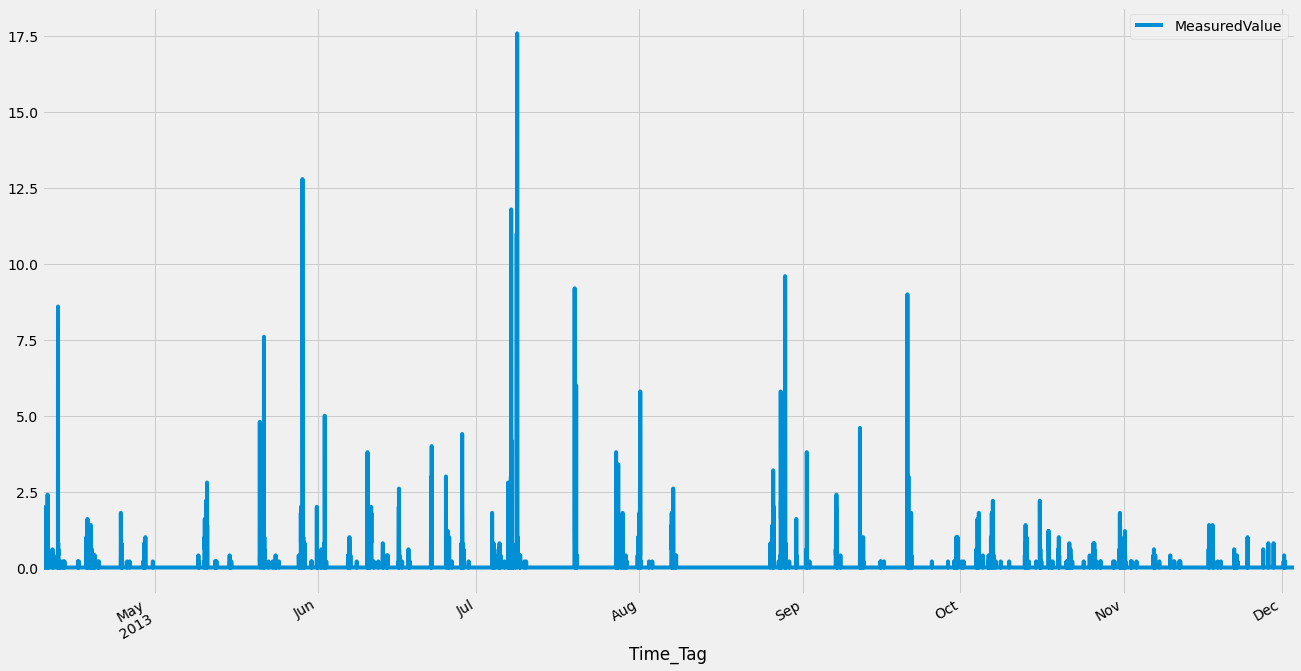

In [ ]:
rain_values.plot(subplots=True, figsize=(20,12))

In [ ]:
rain_values['Time_Tag'] = rain_values.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
rain_warm= rain_values[ (rain_values['Time_Tag']  > 	'2013-04-09') & (rain_values['Time_Tag']  < 	'2013-11-03') ]

In [ ]:
rain_values = rain_warm

In [ ]:
len( rain_warm ) *70 /100


13944.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f80ac34e550>],
      dtype=object)

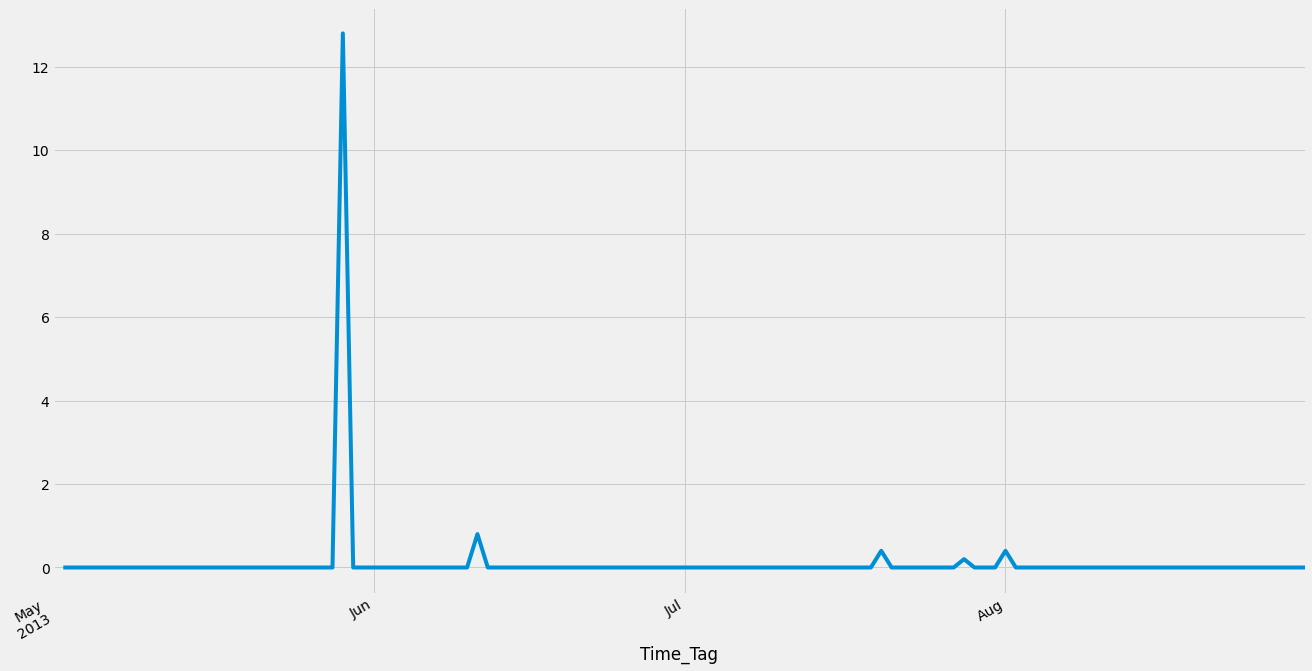

In [ ]:
#detailed view of 2013 year
rain_values.MeasuredValue['2013-05-01':'2013-08-30'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

Sationarity test

In [ ]:
result = adfuller( rain_values.MeasuredValue.dropna( ), maxlag= 100  ) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.510046
p-value: 0.000000


In [ ]:
result = adfuller( rain_values.MeasuredValue.dropna( ), maxlag= 300  ) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.130256
p-value: 0.000000


In [ ]:
#KPSS test 

from statsmodels.tsa.stattools import kpss
def kpss_test(s):
    print ('Results of KPSS Test:')
    kpsstest = kpss( s, regression='c', nlags=None)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [ ]:
kpss_test(rain_values.MeasuredValue)

Results of KPSS Test:
Test Statistic            0.084526
p-value                   0.100000
Lags Used                46.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
rain_values.drop(columns= ['index', 'Time_Tag'], inplace= True)

In [ ]:
rain_values

,MeasuredValue
Time_Tag,
2013-04-09 12:10:00,0.0
2013-04-09 12:25:00,0.0
2013-04-09 12:40:00,0.0
2013-04-09 12:55:00,0.0
2013-04-09 13:10:00,0.0
...,...
2013-11-02 22:55:00,0.0
2013-11-02 23:10:00,0.0
2013-11-02 23:25:00,0.0


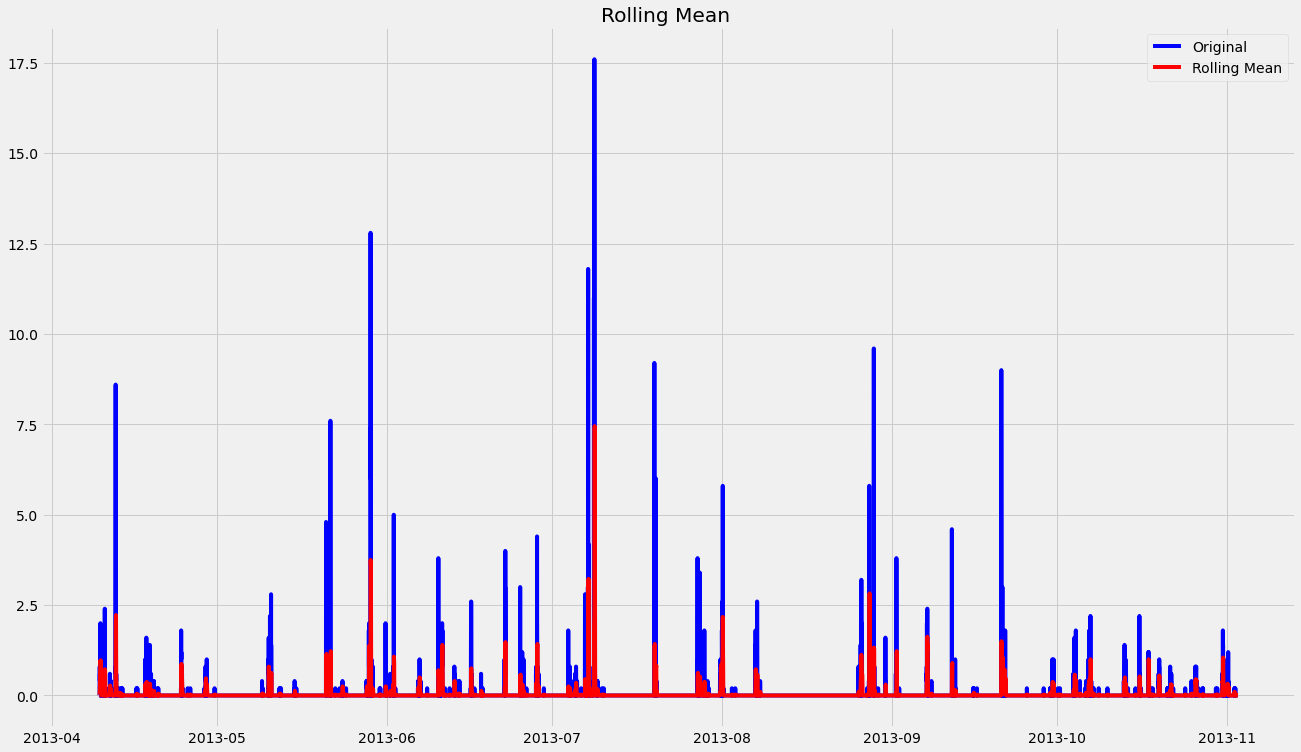

In [ ]:
rolling_mean = rain_values.rolling(window = 8).mean()
rolling_std = rain_values.rolling(window = 8).std()
plt.figure(figsize=(20,12))
plt.plot(rain_values, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.title('Rolling Mean ')
plt.show()

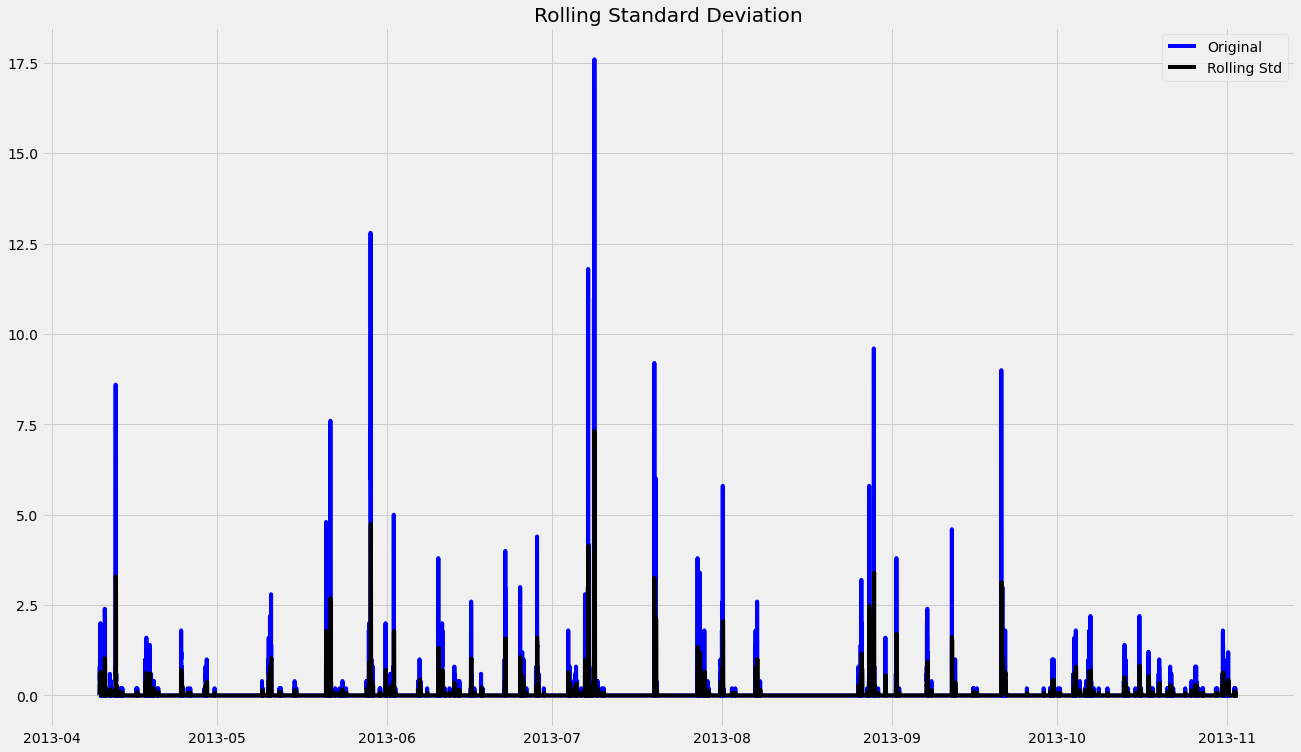

In [ ]:
rolling_mean = rain_values.rolling(window = 8).mean()
rolling_std = rain_values.rolling(window = 8).std()
plt.figure(figsize=(20,12))
plt.plot(rain_values, color = 'blue', label = 'Original')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Standard Deviation')
plt.show()

ACF and PACF

In [ ]:
rain_warm

,MeasuredValue,Time_Tag
Time_Tag,,
2013-04-09 12:10:00,0.0,2013-04-09 12:10:00
2013-04-09 12:25:00,0.0,2013-04-09 12:25:00
2013-04-09 12:40:00,0.0,2013-04-09 12:40:00
2013-04-09 12:55:00,0.0,2013-04-09 12:55:00
2013-04-09 13:10:00,0.0,2013-04-09 13:10:00
...,...,...
2013-11-02 22:55:00,0.0,2013-11-02 22:55:00
2013-11-02 23:10:00,0.0,2013-11-02 23:10:00
2013-11-02 23:25:00,0.0,2013-11-02 23:25:00


In [ ]:
rain_warm

,MeasuredValue,Time_Tag
Time_Tag,,
2013-04-09 12:10:00,0.0,2013-04-09 12:10:00
2013-04-09 12:25:00,0.0,2013-04-09 12:25:00
2013-04-09 12:40:00,0.0,2013-04-09 12:40:00
2013-04-09 12:55:00,0.0,2013-04-09 12:55:00
2013-04-09 13:10:00,0.0,2013-04-09 13:10:00
...,...,...
2013-11-02 22:55:00,0.0,2013-11-02 22:55:00
2013-11-02 23:10:00,0.0,2013-11-02 23:10:00
2013-11-02 23:25:00,0.0,2013-11-02 23:25:00


In [ ]:
df1 = read_csv('/content/drive/MyDrive/Rainfallprediction/2013/Percip2013UHL.csv',  header=0,  index_col=0)
df1.head()

df =  pd.DataFrame(rain_warm['MeasuredValue'])
df.rename(columns={'MeasuredValue':'value'}, inplace = True)

In [ ]:
df.index

DatetimeIndex(['2013-04-09 12:10:00', '2013-04-09 12:25:00',
               '2013-04-09 12:40:00', '2013-04-09 12:55:00',
               '2013-04-09 13:10:00', '2013-04-09 13:25:00',
               '2013-04-09 13:40:00', '2013-04-09 13:55:00',
               '2013-04-09 14:10:00', '2013-04-09 14:25:00',
               ...
               '2013-11-02 21:40:00', '2013-11-02 21:55:00',
               '2013-11-02 22:10:00', '2013-11-02 22:25:00',
               '2013-11-02 22:40:00', '2013-11-02 22:55:00',
               '2013-11-02 23:10:00', '2013-11-02 23:25:00',
               '2013-11-02 23:40:00', '2013-11-02 23:55:00'],
              dtype='datetime64[ns]', name='Time_Tag', length=19920, freq=None)

In [ ]:
#df = rain_values.drop( labels='Time_Tag' , axis=1)
df.reset_index(drop= True , inplace= True)

Some work for the writing of report

In [ ]:
rain_warm. index = rain_warm['Time_Tag']

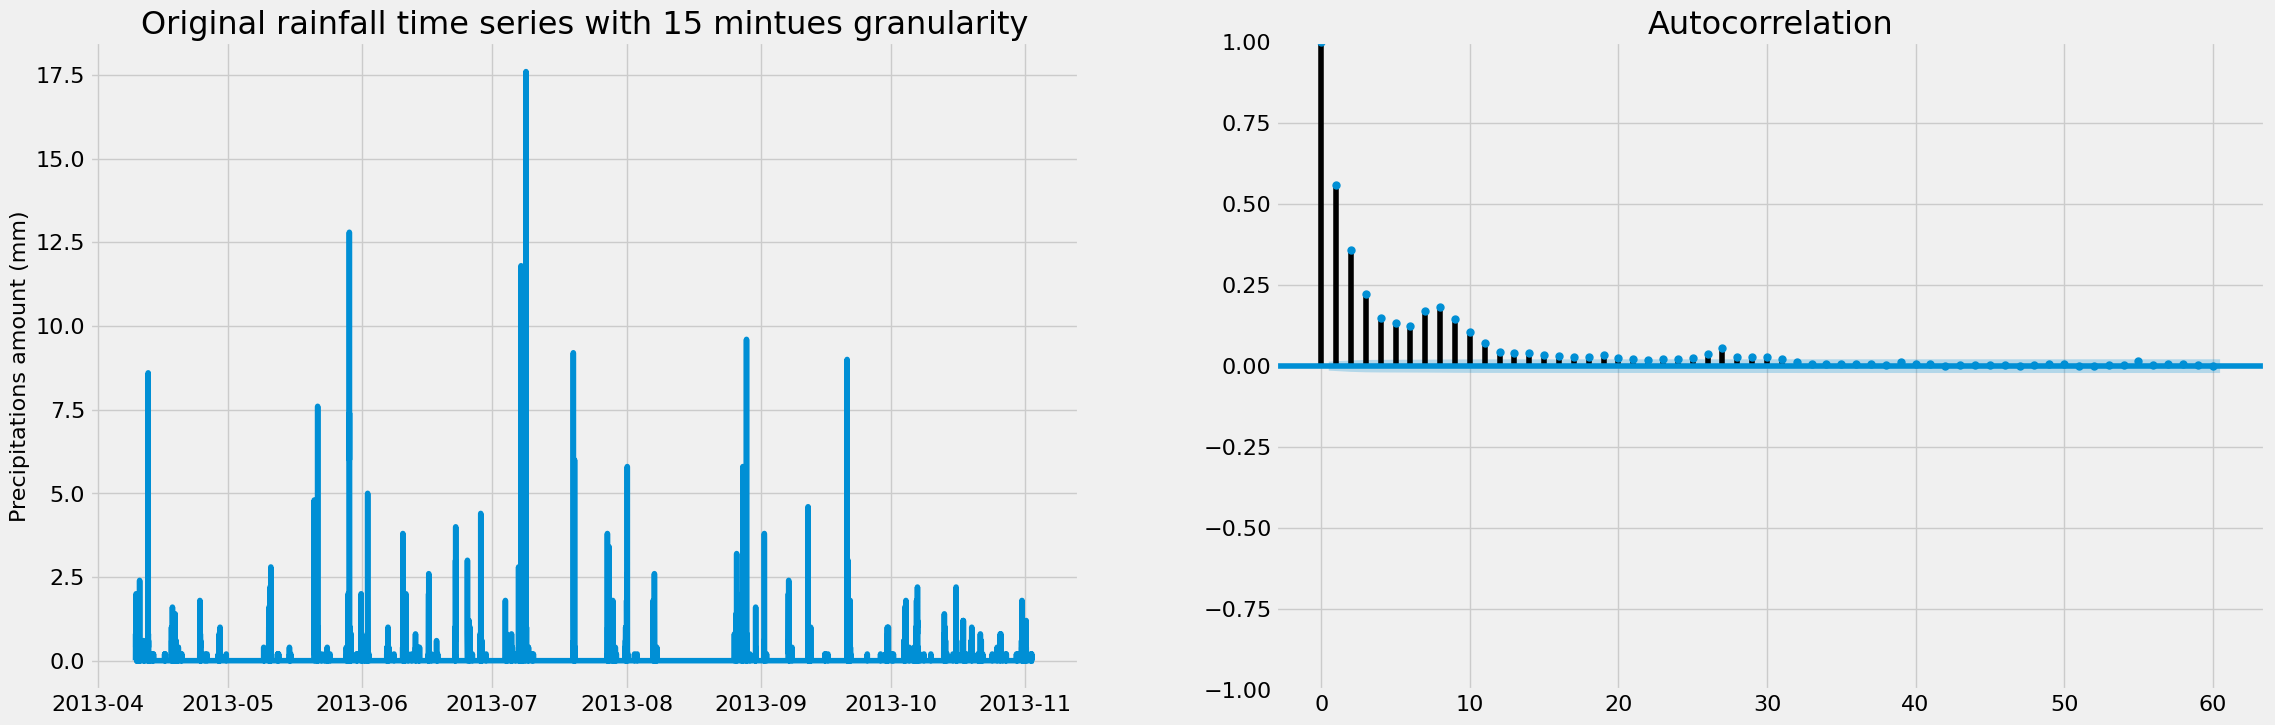

In [ ]:
#ACF
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize':(25,8), 'figure.dpi':100})
# Original Series
#plt.subplots(2, 2,figsize=(16,10))
fig, axes = plt.subplots(1, 2)
axes[0].plot(df.value); 
axes[0].set_title('Original rainfall time series with 15 mintues granularity')
axes[0].set_ylabel('Precipitations amount (mm)', fontsize= 16 )
plot_acf(df.value, lags=60,  ax=axes[1])

# 1st Differencing
#axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
#plot_acf(df.value.diff().dropna(), lags=60,   ax=axes[1, 1])

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


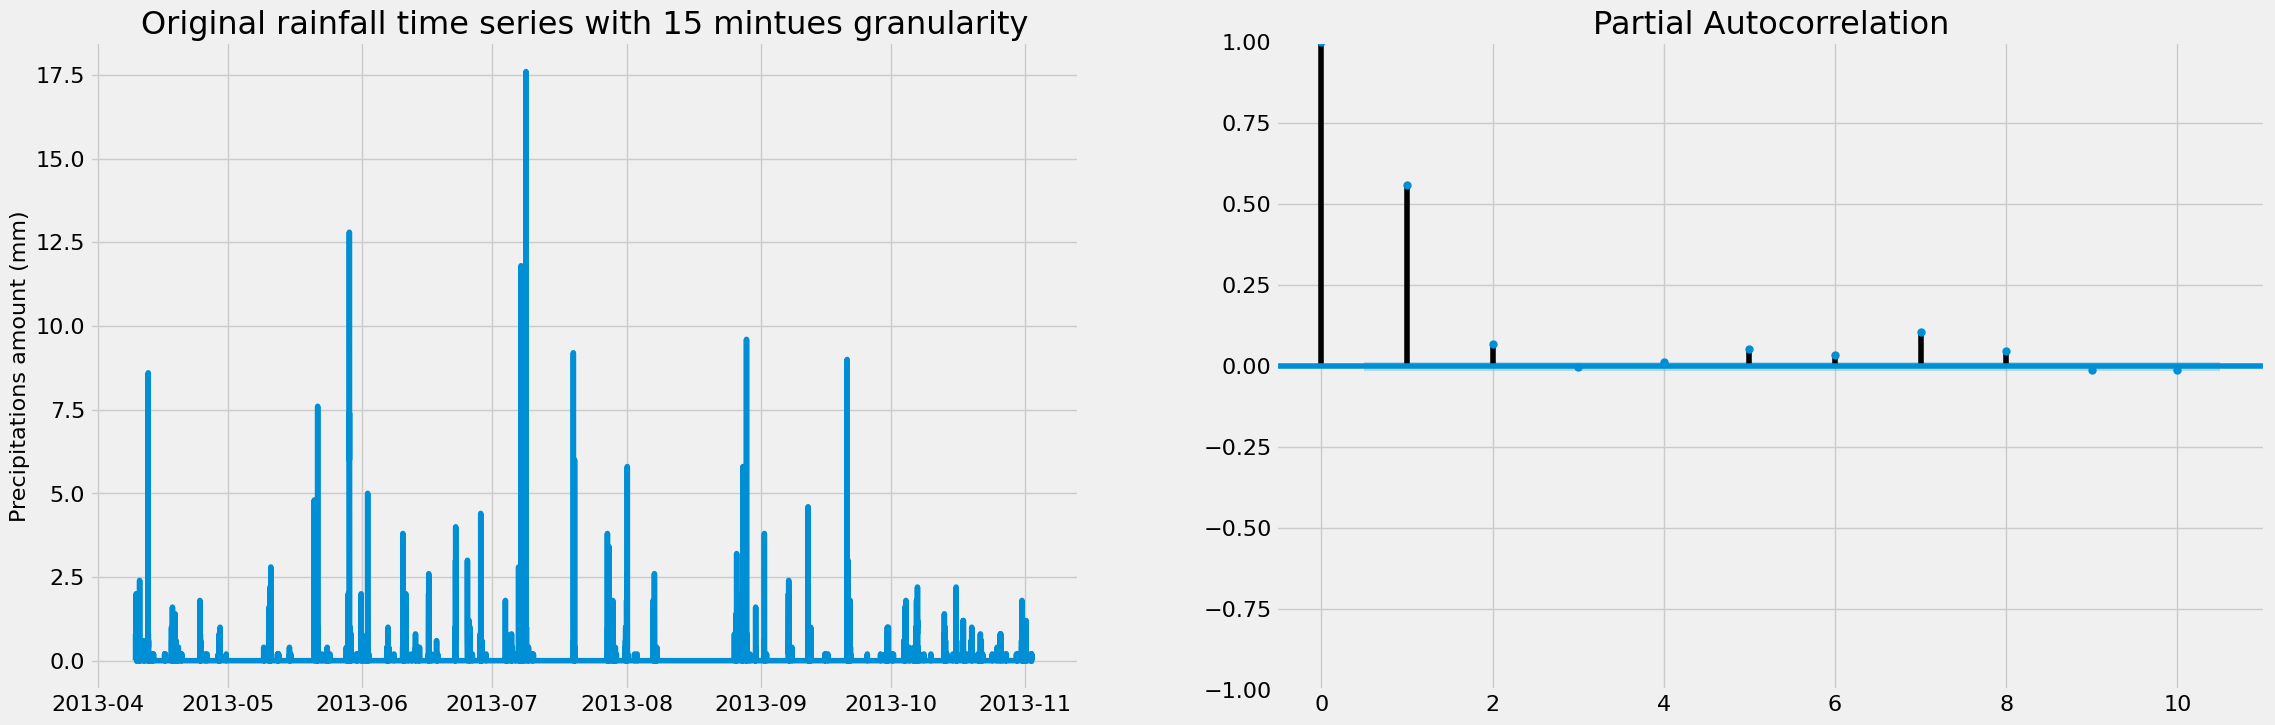

In [ ]:
#PACF 
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize':(25,8), 'figure.dpi':100})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.value);
axes[0].set_title('Original rainfall time series with 15 mintues granularity')
axes[0].set_ylabel('Precipitations amount (mm)', fontsize= 16 )
axes[1].set(ylim=(0,5))
plot_pacf(df.value.dropna(), ax=axes[1], lags= 10 )
plt.show()
# p = 2 

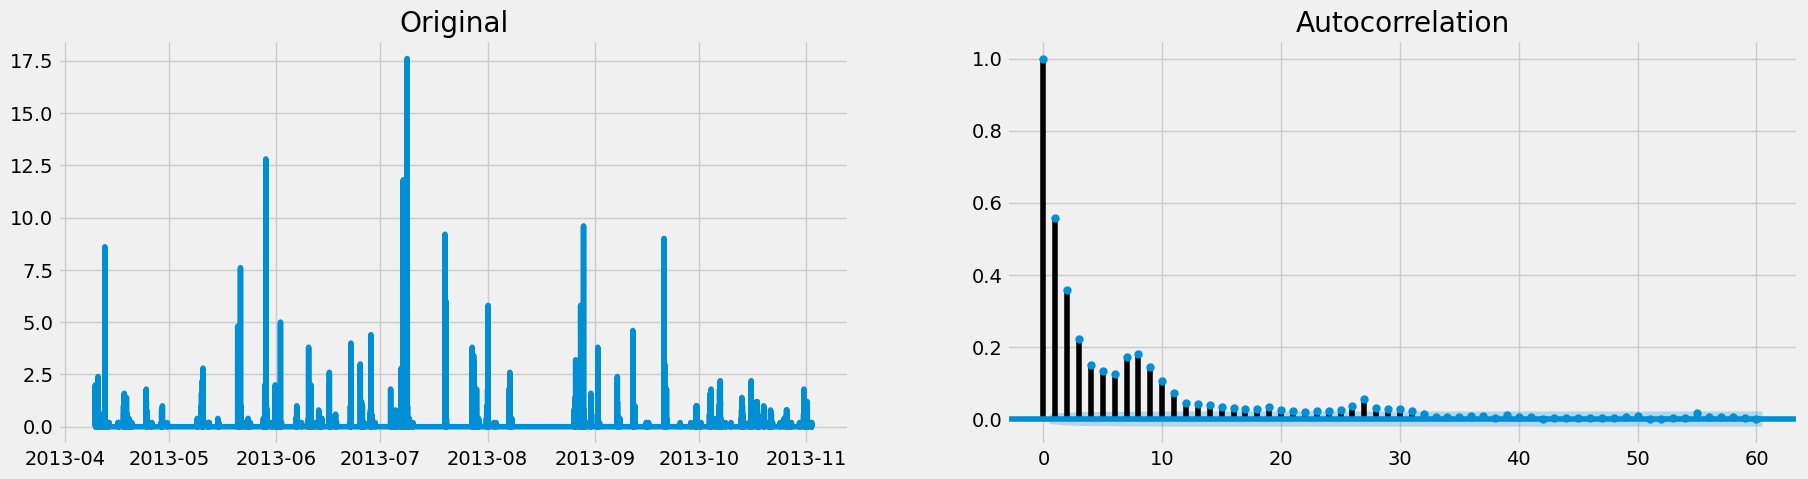

In [ ]:
#ACF

plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
# Original Series
fig, axes = plt.subplots(1, 2)
axes[ 0].plot(df.value); axes[ 0].set_title('Original')
plot_acf(df.value, lags=60,  ax=axes[ 1])
# 1st Differencing
#axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
#plot_acf(df.value.diff().dropna(), lags=60,   ax=axes[1, 1])

plt.show()

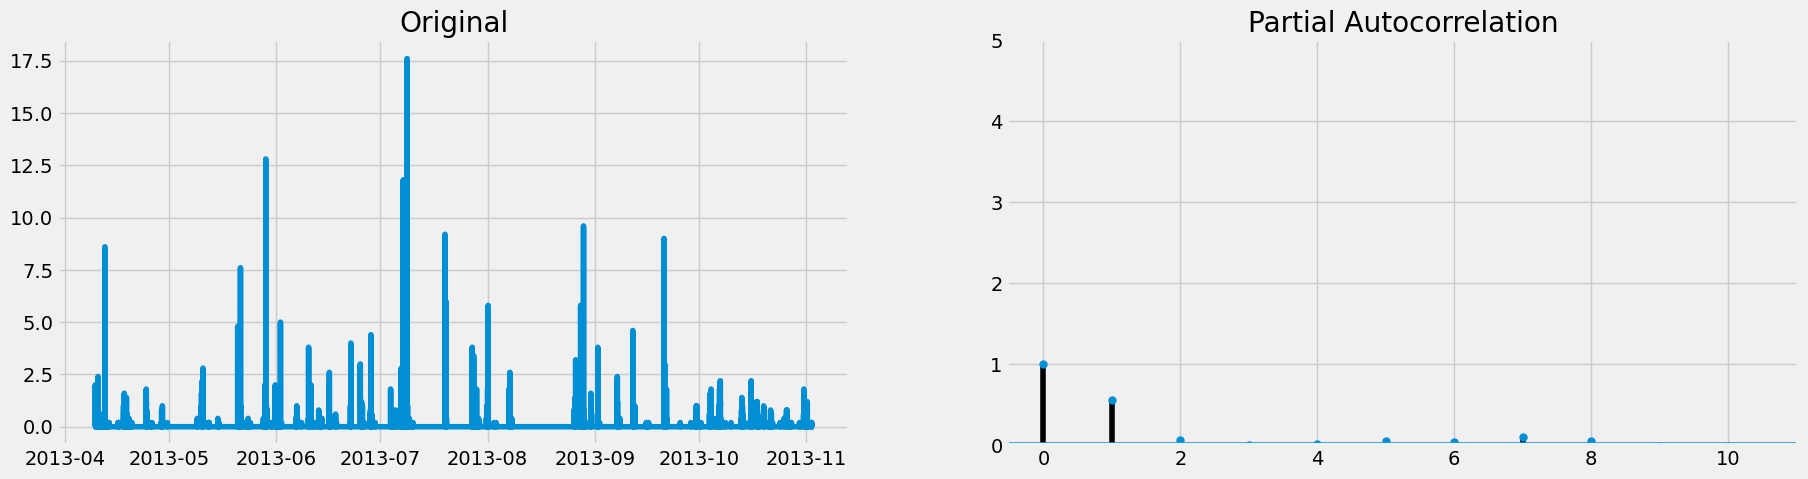

In [ ]:
#PACF 

plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(df.value); axes[0].set_title('Original')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.dropna(), ax=axes[1], lags= 10)
plt.show()
# p = 2 

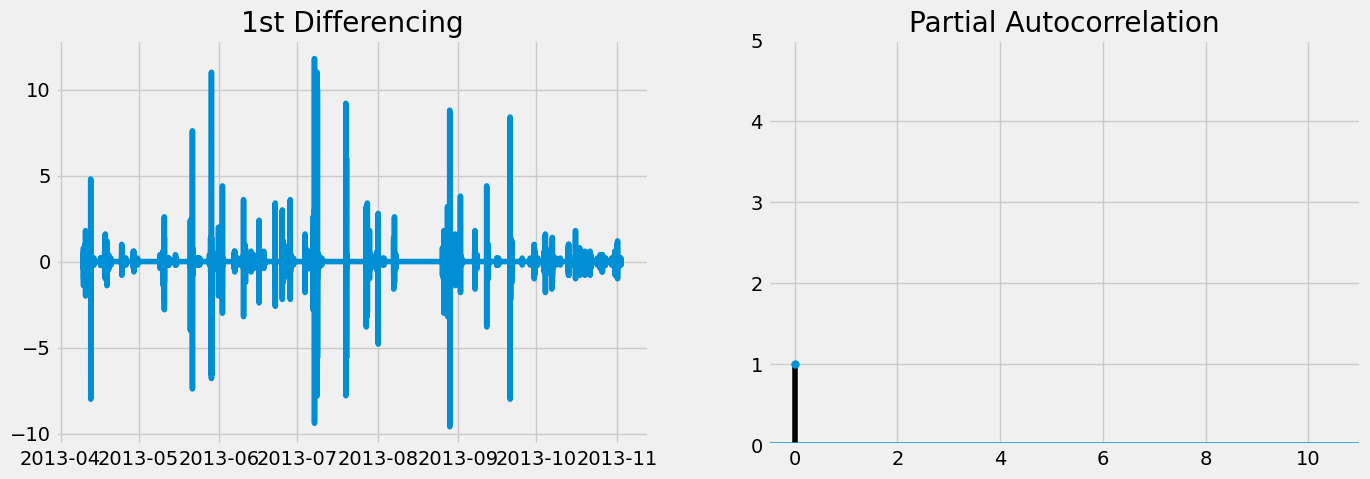

In [ ]:
#Partial auto correlation#

# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1], lags= 10)
plt.show()
# p = 2 

 # Train and test and see performance#

In [ ]:
train = df.value[:13944]
test = df.value[13944:]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9182.951, Time=5.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16175.390, Time=0.70 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9265.256, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11241.728, Time=1.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9184.379, Time=2.56 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9184.788, Time=1.82 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9830.290, Time=1.85 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9182.384, Time=2.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=9134.408, Time=6.95 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9210.148, Time=1.36 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9136.173, Time=5.79 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9135.713, Time=5.95 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 36.391 seconds
                               SARIMAX Results                                
Dep. V

#Trial with test#

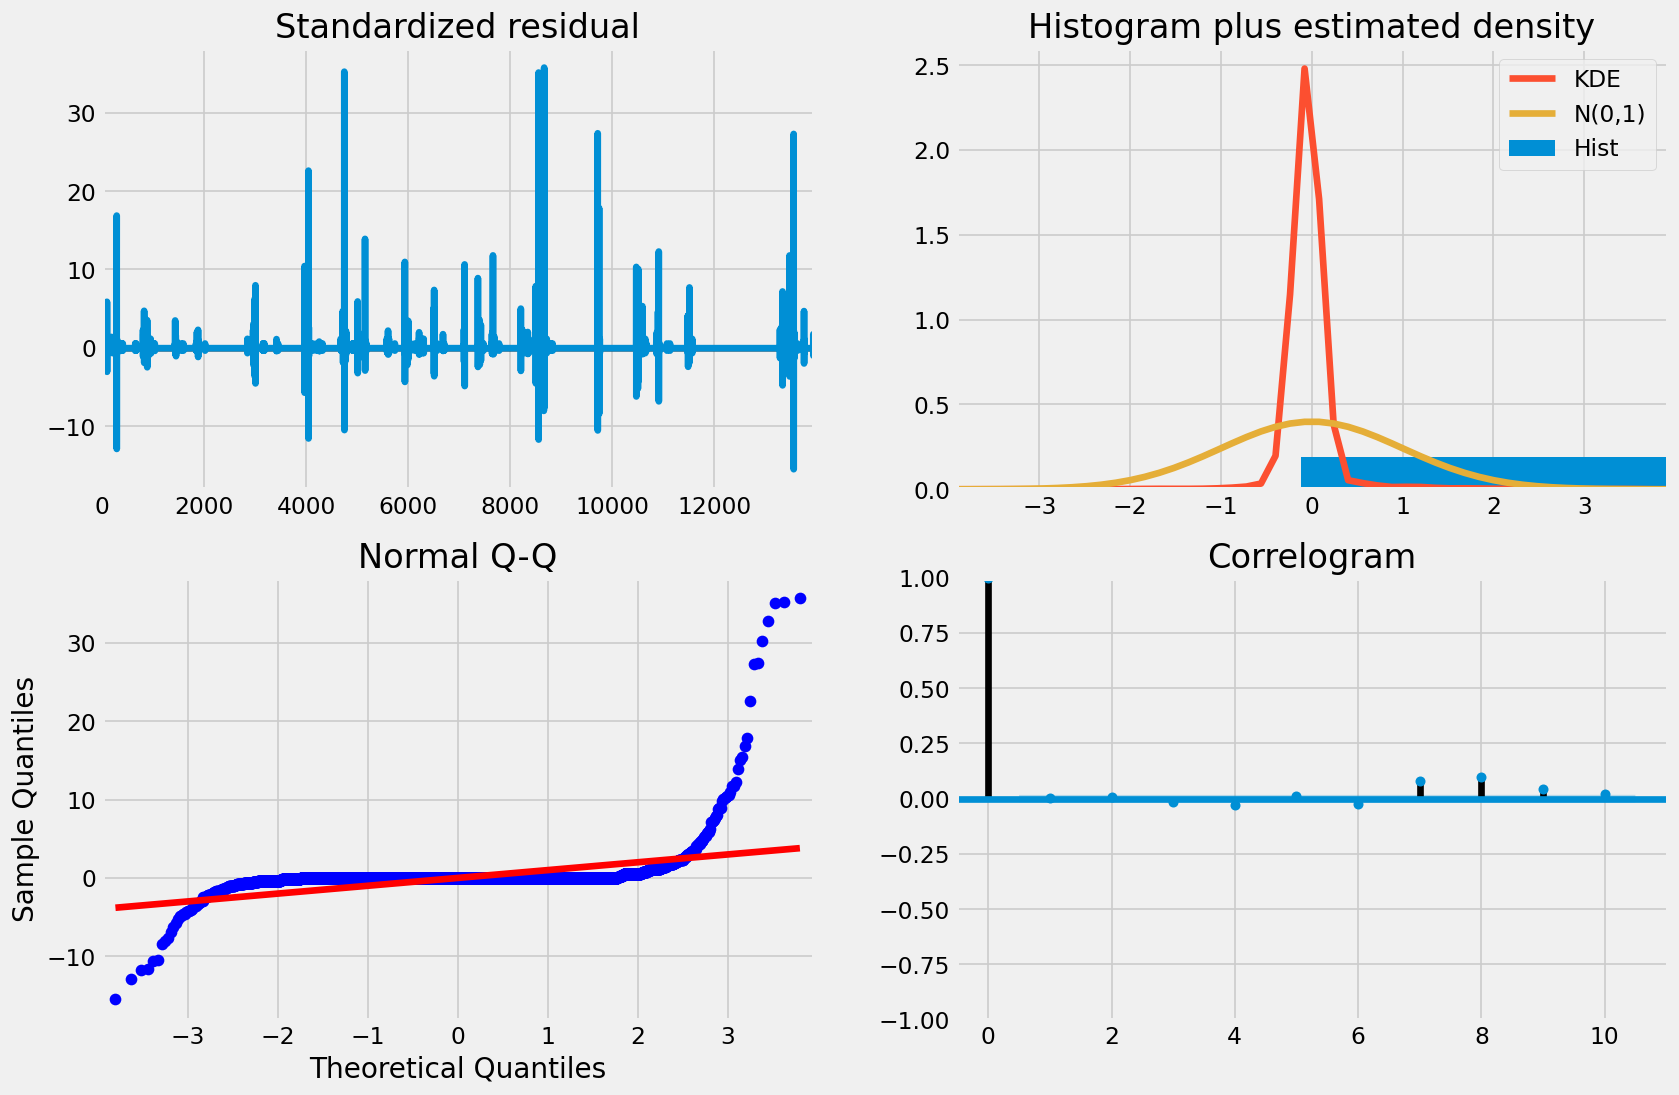

In [ ]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

In [ ]:
#Testing #
test.reset_index(drop= True, inplace= True  )

In [ ]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(2,0,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print(t)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Streaming output truncated to the last 5000 lines.
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
10

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975


In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
predictions
mre_score = max_error (test, predictions)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (test, predictions)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( test, predictions))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(test, predictions)
print('Test R2: %.3f' % r2)


Test MRE: 8.652
Test MAE: 0.043
Test RMSE: 0.190
Test R2: 0.225


#Trying Log return difference#

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:469: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.mean()


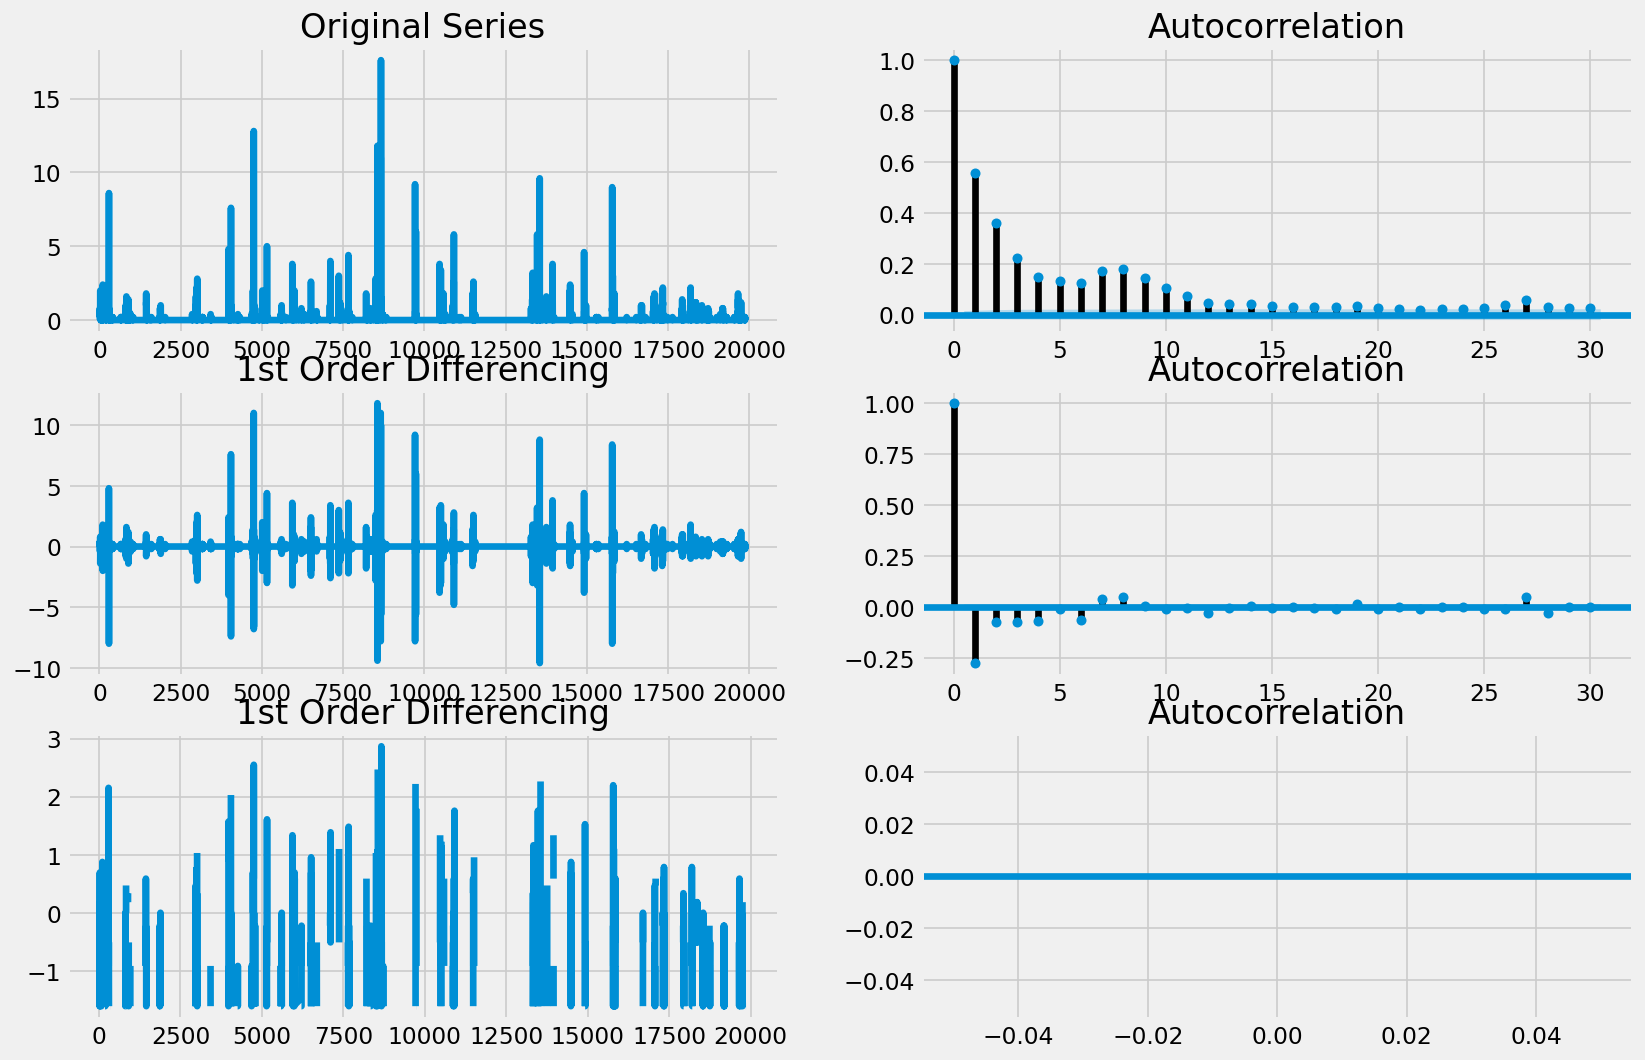

In [ ]:

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, lags=30,  ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), lags=30,   ax=axes[1, 1])

# Log Differencing
axes[2, 0].plot(log(df.value).dropna()); axes[2, 0].set_title('1st Order Differencing')
plot_acf(log(df.value.dropna()), lags=30,   ax=axes[2, 1])


plt.show()

In [ ]:
#Try with differencing 

model = pm.auto_arima(  train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=20, max_q=20, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal= False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=18.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12543.793, Time=2.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11558.463, Time=1.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11015.921, Time=2.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12541.793, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9980.728, Time=7.88 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=30.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9418.006, Time=16.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=46.47 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=9209.591, Time=25.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=9136.655, Time=44.01 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=44.53 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=9198.397, Time=70.74 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=9158.483, Time=52.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AI

In [ ]:

model = pm.auto_arima(  train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=20, max_q=20, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal= False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9143.513, Time=2.86 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14727.574, Time=0.57 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9191.237, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10789.468, Time=0.89 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9142.473, Time=0.95 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9141.734, Time=0.87 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=9142.598, Time=1.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=9144.442, Time=4.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=9108.195, Time=14.33 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9153.212, Time=1.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=9108.318, Time=2.65 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9108.405, Time=4.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9110.242, Time=3.31 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=9110.197, Time=24.05 sec

Best model:  ARIMA(2,0,0)(0,

In [ ]:
test.reset_index(drop=True , inplace=True)

In [ ]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(2,0,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print(t)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720


In [ ]:
predictions
mre_score = max_error (test, predictions)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (test, predictions)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( test, predictions))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(test, predictions)
print('Test R2: %.3f' % r2)

Test MRE: 8.652
Test MAE: 0.043
Test RMSE: 0.190
Test R2: 0.225


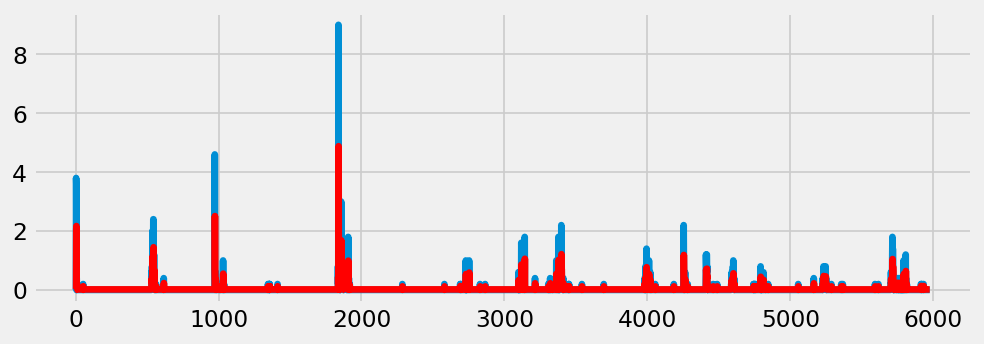

In [ ]:
# plot forecasts against actual outcomes
from matplotlib import pyplot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
test

0       0.0
1       0.0
2       0.0
3       0.0
4       3.8
       ... 
5971    0.0
5972    0.0
5973    0.0
5974    0.0
5975    0.0
Name: value, Length: 5976, dtype: float64

In [ ]:
predictions

[array([0.01705132]),
 array([0.01705009]),
 array([0.01704885]),
 array([0.0170476]),
 array([0.01704638]),
 array([2.05031436]),
 array([2.16886588]),
 array([1.18600842]),
 array([0.11371346]),
 array([0.23272245]),
 array([0.14658638]),
 array([0.0281271]),
 array([0.01735874]),
 array([0.01735747]),
 array([0.01735621]),
 array([0.01735494]),
 array([0.0173537]),
 array([0.01735243]),
 array([0.01735117]),
 array([0.01734991]),
 array([0.01734865]),
 array([0.0173474]),
 array([0.01734614]),
 array([0.01734488]),
 array([0.01734361]),
 array([0.01734236]),
 array([0.01734109]),
 array([0.01733984]),
 array([0.01733859]),
 array([0.01733732]),
 array([0.01733607]),
 array([0.01733481]),
 array([0.01733356]),
 array([0.0173323]),
 array([0.01733103]),
 array([0.01732978]),
 array([0.01732853]),
 array([0.01732728]),
 array([0.01732602]),
 array([0.01732475]),
 array([0.01732351]),
 array([0.01732225]),
 array([0.01732099]),
 array([0.01731974]),
 array([0.01731847]),
 array([0.01731

# Test 15 min granularity for 15, 30, 45 and 60 Lead times 

In [ ]:
len(df)

19920

In [ ]:
df.rename(columns={'MeasuredValue':'value'}, inplace = True)
df.head()


,value,Time_Tag
Time_Tag,,
2013-04-09 12:10:00,0.0,2013-04-09 12:10:00
2013-04-09 12:25:00,0.0,2013-04-09 12:25:00
2013-04-09 12:40:00,0.0,2013-04-09 12:40:00
2013-04-09 12:55:00,0.0,2013-04-09 12:55:00
2013-04-09 13:10:00,0.0,2013-04-09 13:10:00


In [ ]:
len(test)

5976

In [ ]:
train = df.value[:13944]
test = df.value[13944:]

In [ ]:
test.reset_index(drop= True, inplace= True  )

In [ ]:
history = [x for x in train]
predictions_15 = list()
#predictions_30 = list()
#predictions_45 = list()
#predictions_60 = list()
#test_30= list()
#test_45=list()
#test_60=list()
# walk-forward validation
#
for t in range(len(test)-3):
  model = ARIMA(history, order=(2,0,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  predictions_15.append(output[0])
  #print(output[0][1])
  #predictions_30.append(output[0][1])
  #print(output[0])
  #print(output[0])
  #predictions_60.append(output[0][3])
  #predictions_60.append(output[0])
  obs = test[t]
  #test_45.append(test[t+1] )
  #test_60.append(test[t+3] ) 
  #test_60.append(test[t+3] )
  history.append(obs)
  print(t)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625
5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720


15 min predictions results

Study for analysing seperate events 

In [ ]:
predictions_15
mre_score = max_error (test[0:-3], predictions_15)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (test[0:-3], predictions_15)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( test[0:-3], predictions_15))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(test[0:-3], predictions_15)
print('Test R2: %.3f' % r2)


Test MRE: 8.652
Test MAE: 0.043
Test RMSE: 0.190
Test R2: 0.225


In [ ]:
#Analysis of performance on Test data 
y = test[0:-3]
y_hat = predictions_15

In [ ]:
y_y_hat = pd.DataFrame({'y':y , 'y_hat':y_hat} )

In [ ]:
pd.set_option('display.max_rows', 100)

In [ ]:
y_y_hat.iloc[1:99]

,y,y_hat
1,0.0,[0.017050092685989324]
2,0.0,[0.017048850392444595]
3,0.0,[0.017047604320325992]
4,3.8,[0.017046379606252292]
5,3.6,[2.050314358257047]
6,1.8,[2.1688658814520094]
7,0.0,[1.1860084152358374]
8,0.4,[0.11371345967104309]
9,0.2,[0.2327224527874603]
10,0.0,[0.14658637712626266]


In [ ]:
y_y_hat['y_hat'] = y_y_hat['y_hat'].apply(lambda x : x[0])

In [ ]:
y_y_hat

,y,y_hat,residual_error
0,0.0,0.017051,-0.017051
1,0.0,0.017050,-0.017050
2,0.0,0.017049,-0.017049
3,0.0,0.017048,-0.017048
4,3.8,0.017046,3.782954
...,...,...,...
5968,0.0,0.016136,-0.016136
5969,0.0,0.016135,-0.016135
5970,0.0,0.016134,-0.016134
5971,0.0,0.016133,-0.016133


In [ ]:
y_y_hat['residual_error'] = y_y_hat['y'] - y_y_hat['y_hat']

In [ ]:
y_y_hat.describe()

,y,y_hat,residual_error
count,5973.000000,5973.000000,5973.000000
mean,0.032781,0.035887,-0.003106
std,0.215422,0.121221,0.189569
min,0.000000,0.015890,-3.879132
25%,0.000000,0.016356,-0.016884
50%,0.000000,0.016600,-0.016552
75%,0.000000,0.016935,-0.016323
max,9.000000,4.879132,8.651521


In [ ]:
y_y_hat [abs(y_y_hat['residual_error'])>3]

,y,y_hat,residual_error
4,3.8,0.017046,3.782954
974,4.6,0.124367,4.475633
1839,9.0,0.348479,8.651521
1840,1.0,4.879132,-3.879132


In [ ]:
predictions_15
mre_score = max_error (test[0:-3], predictions_15)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (test[0:-3], predictions_15)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( test[0:-3], predictions_15))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(test[0:-3], predictions_15)
print('Test R2: %.3f' % r2)


Test MRE: 8.652
Test MAE: 0.043
Test RMSE: 0.190
Test R2: 0.225


In [ ]:
# Scores on rain and no rain tuples seperately 

results  = pd.DataFrame( { 'true' :test[0:-3] , 'prediction':predictions_15 } )
print ("Scores on rain tupes \n")

results_true_rain = results[results['true']!=0].true
results_prediction_rain = results[results['true']!=0].prediction
mre_score = max_error ( results_true_rain,results_prediction_rain )
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_rain, results_prediction_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_rain, results_prediction_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_rain, results_prediction_rain)
print('Test R2: %.3f' % r2)


print ("\n Scores on no-rain tupes \n")
results_true_no_rain = results[results['true']==0].true
results_prediction_no_rain = results[results['true']==0].prediction

mre_score = max_error (results_true_no_rain, results_prediction_no_rain)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_no_rain, results_prediction_no_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_no_rain, results_prediction_no_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_no_rain, results_prediction_no_rain)
print('Test R2: %.3f' % r2)

Scores on rain tupes 

Test MRE: 8.652
Test MAE: 0.384
Test RMSE: 0.756
Test R2: -0.161

 Scores on no-rain tupes 

Test MRE: 1.186
Test MAE: 0.021
Test RMSE: 0.042
Test R2: 0.000


30 minutes prediction results

In [ ]:
predictions_30
mre_score = max_error (test_30, predictions_30)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (test_30, predictions_30)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( test_30, predictions_30))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(test_30, predictions_30)
print('Test R2: %.3f' % r2)

Test MRE: 8.881
Test MAE: 0.053
Test RMSE: 0.203
Test R2: 0.109


In [ ]:
# Scores on rain and no rain tuples seperately 

results  = pd.DataFrame( { 'true' :test_30 , 'prediction':predictions_30 } )
print ("Scores on rain tupes \n")

results_true_rain = results[results['true']!=0].true
results_prediction_rain = results[results['true']!=0].prediction
mre_score = max_error ( results_true_rain,results_prediction_rain )
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_rain, results_prediction_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_rain, results_prediction_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_rain, results_prediction_rain)
print('Test R2: %.3f' % r2)


print ("\n Scores on no-rain tupes \n")
results_true_no_rain = results[results['true']==0].true
results_prediction_no_rain = results[results['true']==0].prediction

mre_score = max_error (results_true_no_rain, results_prediction_no_rain)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_no_rain, results_prediction_no_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_no_rain, results_prediction_no_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_no_rain, results_prediction_no_rain)
print('Test R2: %.3f' % r2)

Scores on rain tupes 

Test MRE: 8.881
Test MAE: 0.425
Test RMSE: 0.811
Test R2: -0.334

 Scores on no-rain tupes 

Test MRE: 1.387
Test MAE: 0.029
Test RMSE: 0.045
Test R2: 0.000


45 min prediction results

In [ ]:
predictions_45
mre_score = max_error (test_45, predictions_45)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (test_45, predictions_45)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( test_45, predictions_45))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(test_45, predictions_45)
print('Test R2: %.3f' % r2)

Test MRE: 8.797
Test MAE: 0.059
Test RMSE: 0.208
Test R2: 0.066


In [ ]:
# Scores on rain and no rain tuples seperately 

results  = pd.DataFrame( { 'true' :test_45 , 'prediction':predictions_45 } )
print ("Scores on rain tupes \n")

results_true_rain = results[results['true']!=0].true
results_prediction_rain = results[results['true']!=0].prediction
mre_score = max_error ( results_true_rain,results_prediction_rain )
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_rain, results_prediction_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_rain, results_prediction_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_rain, results_prediction_rain)
print('Test R2: %.3f' % r2)


print ("\n Scores on no-rain tupes \n")
results_true_no_rain = results[results['true']==0].true
results_prediction_no_rain = results[results['true']==0].prediction

mre_score = max_error (results_true_no_rain, results_prediction_no_rain)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_no_rain, results_prediction_no_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_no_rain, results_prediction_no_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_no_rain, results_prediction_no_rain)
print('Test R2: %.3f' % r2)

Scores on rain tupes 

Test MRE: 8.797
Test MAE: 0.454
Test RMSE: 0.827
Test R2: -0.386

 Scores on no-rain tupes 

Test MRE: 2.004
Test MAE: 0.034
Test RMSE: 0.051
Test R2: 0.000


In [ ]:
len(test_60)

5973

In [ ]:
len(predictions_60)

5973

60 minutes predictions results

In [ ]:
predictions_60
mre_score = max_error (test_60, predictions_60)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (test_60, predictions_60)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( test_60, predictions_60))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(test_60, predictions_60)
print('Test R2: %.3f' % r2)

Test MRE: 8.966
Test MAE: 0.063
Test RMSE: 0.211
Test R2: 0.043


In [ ]:
# Scores on rain and no rain tuples seperately 

results  = pd.DataFrame( { 'true' :test_60 , 'prediction':predictions_60 } )
print ("Scores on rain tupes \n")

results_true_rain = results[results['true']!=0].true
results_prediction_rain = results[results['true']!=0].prediction
mre_score = max_error ( results_true_rain,results_prediction_rain )
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_rain, results_prediction_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_rain, results_prediction_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_rain, results_prediction_rain)
print('Test R2: %.3f' % r2)


print ("\n Scores on no-rain tupes \n")
results_true_no_rain = results[results['true']==0].true
results_prediction_no_rain = results[results['true']==0].prediction

mre_score = max_error (results_true_no_rain, results_prediction_no_rain)
print('Test MRE: %.3f' % mre_score)
mae_score = mean_absolute_error (results_true_no_rain, results_prediction_no_rain)
print('Test MAE: %.3f' % mae_score)
rmse_score = np.sqrt(mean_squared_error( results_true_no_rain, results_prediction_no_rain))
print('Test RMSE: %.3f' % rmse_score)
r2 = r2_score(results_true_no_rain, results_prediction_no_rain)
print('Test R2: %.3f' % r2)

Scores on rain tupes 

Test MRE: 8.966
Test MAE: 0.472
Test RMSE: 0.844
Test R2: -0.446

 Scores on no-rain tupes 

Test MRE: 1.279
Test MAE: 0.036
Test RMSE: 0.042
Test R2: 0.000
